In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from pyproj import Transformer
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd

In [26]:
# Load Datasets
cwd = Path.cwd()

# EDA → Python → Scripts → Project and then down into Data/covariates
covariates_dir = cwd.parents[2] / "Data" / "covariates"

In [27]:
# Read the ethnic_group_2021.csv file to start exploring
schools_df = pd.read_csv(covariates_dir / "schools_location.csv")
schools_df

,URN,LA (code),Easting,Northing,MSOA (name),LSOA (name)
0,100000,201,533498.0,181201.0,City of London 001,City of London 001F
1,100001,201,532301.0,181746.0,City of London 001,City of London 001B
2,100002,201,532160.0,181151.0,City of London 001,City of London 001F
3,100003,201,531981.0,180844.0,City of London 001,City of London 001F
4,100004,202,528515.0,184869.0,Camden 007,Camden 007D
...,...,...,...,...,...,...
49324,402456,680,332023.0,186933.0,Newport 018,Newport 018C
49325,402457,669,227965.0,216407.0,Carmarthenshire 027,Carmarthenshire 027B
49326,402458,666,310627.0,291292.0,Powys 008,Powys 008A
49327,402459,680,331927.0,188695.0,Newport 011,Newport 011E


In [28]:
schools_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49329 entries, 0 to 49328
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   URN          49329 non-null  int64  
 1   LA (code)    49329 non-null  int64  
 2   Easting      47812 non-null  float64
 3   Northing     47812 non-null  float64
 4   MSOA (name)  48013 non-null  object 
 5   LSOA (name)  48011 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 2.3+ MB


In [29]:
schools_df.describe()

,URN,LA (code),Easting,Northing
count,49329.000000,49329.000000,47812.000000,47812.000000
mean,137561.916276,686.078737,442042.860788,280060.478457
std,61852.200085,260.459889,93212.168450,126710.772631
min,100000.000000,0.000000,0.000000,0.000000
25%,112342.000000,372.000000,384745.000000,178393.000000
50%,124682.000000,838.000000,438587.000000,268328.500000
75%,137765.000000,888.000000,518080.250000,389168.500000
max,402460.000000,941.000000,655133.000000,811856.000000


In [30]:
schools_df.nunique()

URN            49329
LA (code)        186
Easting        32430
Northing       32713
MSOA (name)     7136
LSOA (name)    20616
dtype: int64

In [31]:
# Schools per local authority
schools_per_LA = schools_df['LA (code)'].value_counts().sort_index()
print("\nSchools per LA (first 10):")
print(schools_per_LA.head(10))


Schools per LA (first 10):
LA (code)
0      142
201      8
202    142
203    204
204    201
205    153
206    137
207    119
208    206
209    151
Name: count, dtype: int64


In [32]:
# Define the transformer for British National Grid (EPSG:27700) to WGS84 (EPSG:4326)
transformer = Transformer.from_crs("EPSG:27700", "EPSG:4326", always_xy=True)

# Create a new DataFrame with converted coordinates
schools_geo_df = schools_df.copy()
schools_geo_df["Latitude"], schools_geo_df["Longitude"] = zip(*schools_geo_df.apply(lambda row: transformer.transform(row["Easting"], row["Northing"]), axis=1))

schools_geo_df.head()

,URN,LA (code),Easting,Northing,MSOA (name),LSOA (name),Latitude,Longitude
0,100000,201,533498.0,181201.0,City of London 001,City of London 001F,-0.077531,51.513969
1,100001,201,532301.0,181746.0,City of London 001,City of London 001B,-0.094566,51.519148
2,100002,201,532160.0,181151.0,City of London 001,City of London 001F,-0.096820,51.513834
3,100003,201,531981.0,180844.0,City of London 001,City of London 001F,-0.099513,51.511117
4,100004,202,528515.0,184869.0,Camden 007,Camden 007D,-0.147963,51.548087


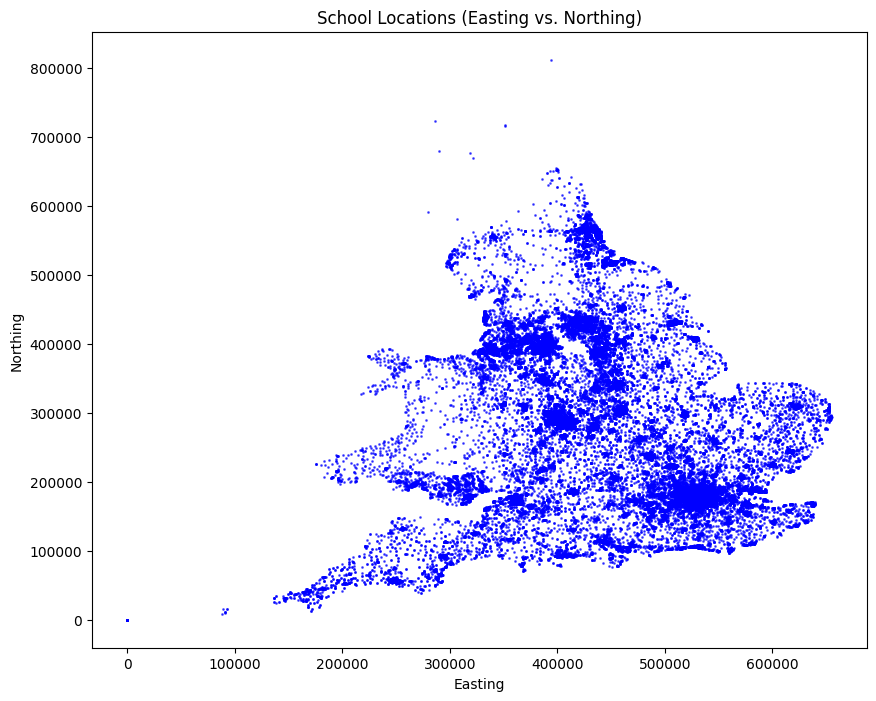

In [34]:
# Filter out missing values
schools_plot_df = schools_geo_df.dropna(subset=['Easting', 'Northing'])

# Create the plot
plt.figure(figsize=(10, 8))
plt.scatter(schools_plot_df['Easting'], schools_plot_df['Northing'], alpha=0.6, c='blue', marker='o', s=1)

# Add labels and title
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title("School Locations (Easting vs. Northing)")

# Show the plot
plt.show()

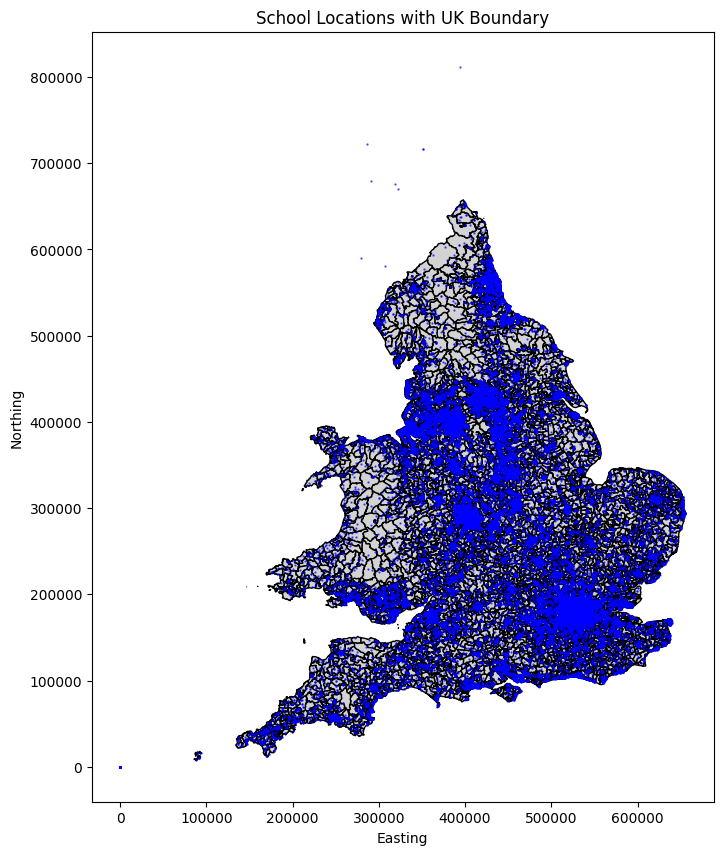

In [43]:
# Load UK boundary shapefile (update path to your file)
lsoa_boundaries = cwd.parents[2] / "Data" / "LSOA" / "Lower_layer_Super_Output_Areas_December_2021_Boundaries_EW_BSC_V4_-5236167991066794441"
uk_boundary = gpd.read_file(lsoa_boundaries /"LSOA_2021_EW_BSC_V4.shp")

# Filter out missing values in school locations
schools_plot_df = schools_geo_df.dropna(subset=['Easting', 'Northing'])

# Create the plot
fig, ax = plt.subplots(figsize=(14, 10))

# Plot country boundary
uk_boundary.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot school locations
ax.scatter(schools_plot_df['Easting'], schools_plot_df['Northing'], alpha=0.6, c='blue', marker='o', s=0.5)

# Add labels and title
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ax.set_title("School Locations with UK Boundary")

plt.show()